# TOF Sensor Basic Tests

## Objective

To evaluate WaveShare Time of Flight (TOF) sensor's suitability for the project by testing its ability to measure various distances under different lighting conditions.

## Experiment Details

### Experiment Setup

- **Sensor Positioning**: At regular 0.5m intervals ranging from 0.5m to 5.0m, with the sensor directed at a wall.
- **Test Environments**: Indoors, outdoors, and outdoors with a 3D-printed shade.
- **Data Collection**: Each test generated approximately 500 distance measurement points.

### Data Extraction

- **Indoors & Outdoors**: Utilized WaveShare's official software to transfer data into Excel files.
- **Outdoors with Shade**: Employed a Raspberry Pi and custom Python code to save the data into a text file. 

## Data Strucutre and Cleanup

- **File Organization**: Each distance interval (e.g., 0.5m, 1.0m, etc.) stores its measurements in a separate file located in their respective folders.
- **WaveShare Software**: I extract distance values from the Excel files generated by the software.
- **Raspberry Pi**: Every measurement from the Raspberry Pi includes time, distance and signal strength:

    ```text
    09:48:30 1030 659
    ```

- I keep the distances and filter out time and signal strength.

## Sensor Specification

According to WaveShare's [documentation](https://www.waveshare.com/wiki/TOF_Laser_Range_Sensor#Specification):

- Natural light can affect the TOF sensor's accuracy.
- The anticipated accuracy and deviation for different ranges are as follows:

||Short Range (0 to 2.16m)|Mid Range (2.16 to 3.60 m)|Long Range (> 3.60m)|
|---|---|---|---|
|Accuracy|±1.0cm|±1.0cm|±1.5cm|
|Standard Deviation|0.3cm|1.5cm|8cm|

Given this information, outdoor readings are hypothesized to be less precise and accurate than indoor ones.

## Code Setup

### Imports

To maintain a clean and organized notebook, various functionalities have been distributed into separate Python modules:

- [`cleaner.py`](../src/data/cleaner.py) includes data cleaning functions.
- [`processing.py`](../src/data/processing.py) includes data processing functions.
- [`loader.py`](../src/data/loader.py) aids in extracting sensor data from text files.
- [`basic_graphs.py`](../src/graphing/basic_graphs.py) provides utilities for data visualization.

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd

from cycling_safety_analysis.data import cleaner, processing
from cycling_safety_analysis.data.loader import FolderData
from cycling_safety_analysis.graphing import basic_graphs

### Data Preparation and Loading

I define the list of actual distances measured and load the data files.

In [2]:
ACTUAL_DISTANCES = [0.5 * i for i in range(1, 11)]

INDOORS_DATA_PATH = pathlib.Path("../data/processed/tof_basic_tests/indoors/")
OUTDOORS_DATA_PATH = pathlib.Path("../data/processed/tof_basic_tests/outdoors/")
WITH_SHADE_DATA_PATH = pathlib.Path("../data/processed/tof_basic_tests/with_shade/")

indoors_data = FolderData(INDOORS_DATA_PATH)
outdoors_data = FolderData(OUTDOORS_DATA_PATH)
with_shade_data = FolderData(WITH_SHADE_DATA_PATH)

## Data Analysis

### Accuracy Assessment

- **Objective**: The sensor's accuracy is evaluated by comparing the mean measured distance to the actual distance at each interval.
- **Explanation**: Accuracy in our tests refers to how close our measurements are to the true values.
- **Analysis**: From the table below, we can see that the distance measured by the sensor at each interval, under both indoor and outdoor conditions, starts to move away from the actual distances the further the distance. The indoor data appears to remain consistent longer than the outdoor data.

In [3]:
indoors_mean = processing.get_mean(indoors_data.distances)
outdoors_mean = processing.get_mean(outdoors_data.distances)
with_shade_mean = processing.get_mean(with_shade_data.distances)

data = {
    "Actual Distance": ACTUAL_DISTANCES,
    "Outdoors Mean": outdoors_mean,
    "Indoors Mean": indoors_mean,
    "With Shade Mean": with_shade_mean
}
df = pd.DataFrame(data)
display(df.T)

,0,1,2,3,4,5,6,7,8,9
Actual Distance,0.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,4.50,5.00
Outdoors Mean,0.50,1.01,1.54,2.10,2.60,2.96,3.30,3.30,3.31,2.99
Indoors Mean,0.52,1.00,1.50,2.02,2.50,3.02,3.52,4.04,4.36,4.06
With Shade Mean,0.50,1.00,1.50,1.96,2.38,2.83,3.06,2.49,2.75,1.70


From the presented graphs, the sensor excels in indoor settings, accurately gauging distances up to 4.0m. Conversely, outdoors, it's accurate only up to 3.0m, beyond which it struggles. A notable dip in average measurements is observed at 5.0m in both settings, likely due to increased erroneous data skewing the average downwards. Surprisingly, the sensor's performance deteriorates outdoors with a shade. This might be attributed to the shade obstructing the sensor's readings, especially when there's a slight tilt in its angle, hindering accurate data collection beyond 3.0m.

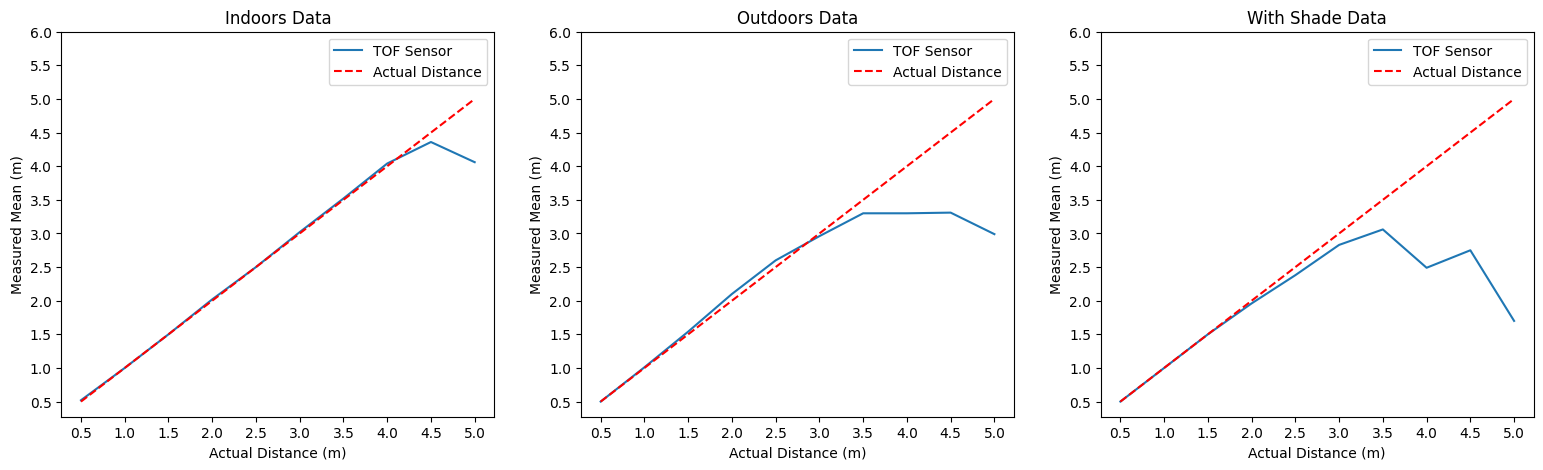

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(19, 5))
basic_graphs.plot_mean_vs_actual_distance(axes[0], indoors_mean, "Indoors Data")
basic_graphs.plot_mean_vs_actual_distance(axes[1], outdoors_mean, "Outdoors Data")
basic_graphs.plot_mean_vs_actual_distance(axes[2], with_shade_mean, "With Shade Data")
plt.show()

### Precision Assessment

- **Objective**: The sensor's precision is evaluated by plotting a scatter plot of the raw data and analyzing the spread of the points.
- **Explanation**: Precision in our tests refers to how close our measurements are to each other.
- **Analysis**: Evaluating the sensor's precision via a scatter plot, we find marked disparities in its performance indoors versus outdoors. Outdoors, especially in bright daylight, the sensor begins to produce significant spurious data from 1.5m. In contrast, indoors, its precision holds firm, generating minimal errant data up to 3.5m. The introduction of a shade outdoors marginally improves precision for closer distances, suggesting that a shade can enhance sensor reliability at proximate ranges.

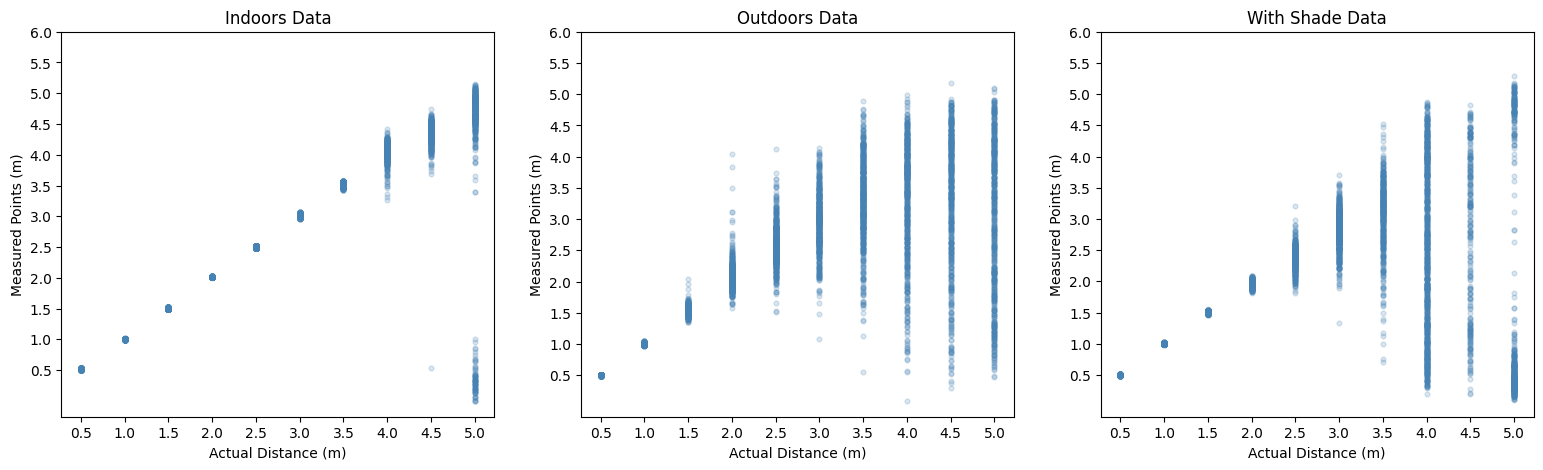

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(19, 5))
basic_graphs.plot_scatter(axes[0], indoors_data.distances, "Indoors Data")
basic_graphs.plot_scatter(axes[1], outdoors_data.distances, "Outdoors Data")
basic_graphs.plot_scatter(axes[2], with_shade_data.distances, "With Shade Data")
plt.show()

### Reliability Assessment: Standard Deviation

- **Objective**: Visualize the consistency and precision of the TOF sensor in each environment via standard deviation.
- **Explanation**: The standard deviation provides a measure of the spread of our measurements. In our context, a smaller standard deviation indicates that our measurements are tightly packed around the average value, hinting at both accuracy and precision.
- **Analysis**: When plotting the standard deviation for each measurement interval, the sensor's precision is notably affected by strong daylight, showing a marked increase in deviation post the 2.0m mark. Indoors, however, the deviation remains impressively low until 4.5m, reinforcing the sensor's sensitivity to natural light. Notably, using a shade improves precision for closer distances, with reduced deviation until 3.5m, suggesting the shade prioritizes improved close-range measurements at the expense of distant readings.

,0,1,2,3,4,5,6,7,8,9
Indoors,0.01,0.01,0.01,0.01,0.01,0.02,0.03,0.14,0.22,1.58
Outdoors,0.00,0.01,0.07,0.23,0.34,0.48,0.66,0.92,1.08,1.22
Shade,0.00,0.01,0.01,0.05,0.18,0.30,0.58,1.31,1.31,1.92


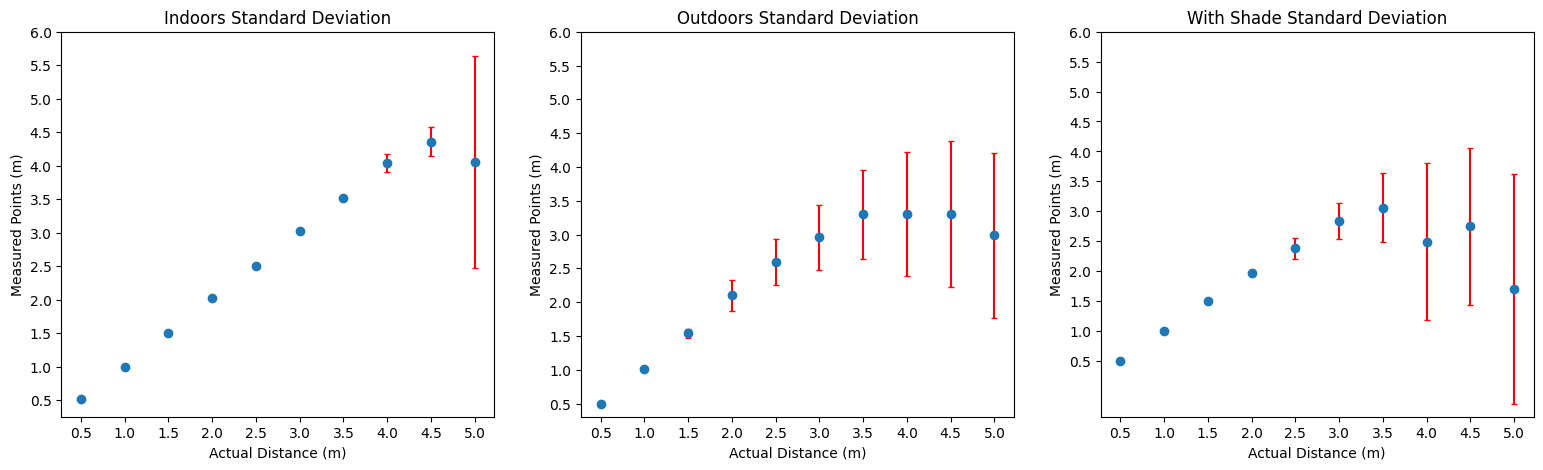

In [6]:
indoors_std = processing.get_std(indoors_data.distances)
outdoors_std = processing.get_std(outdoors_data.distances)
with_shade_std = processing.get_std(with_shade_data.distances)

std_data = {
    "Indoors": indoors_std,
    "Outdoors": outdoors_std,
    "Shade": with_shade_std
}
df = pd.DataFrame(std_data)
display(df.T)

fig, axes = plt.subplots(1, 3, figsize=(19, 5))
basic_graphs.plot_std_errorbar(axes[0], indoors_mean, indoors_std, "Indoors Standard Deviation")
basic_graphs.plot_std_errorbar(axes[1], outdoors_mean, outdoors_std, "Outdoors Standard Deviation")
basic_graphs.plot_std_errorbar(axes[2], with_shade_mean, with_shade_std, "With Shade Standard Deviation")
plt.show()

### Reliability Assessment: Best Fit Line

- **Objective**: Compare the line of best fit for each dataset to gauge the sensor's reliability.
- **Explanation**: The best fit line provides a visual representation of the correlation between measured values and actual values. A slope close to 1 implies a direct, proportional relationship.
- **Data Cleaning**: However, the prevalence of spurious data could compromise the curve's accuracy. To enhance this, one approach is data preprocessing—specifically, discarding data points exceeding one standard deviation from the mean.

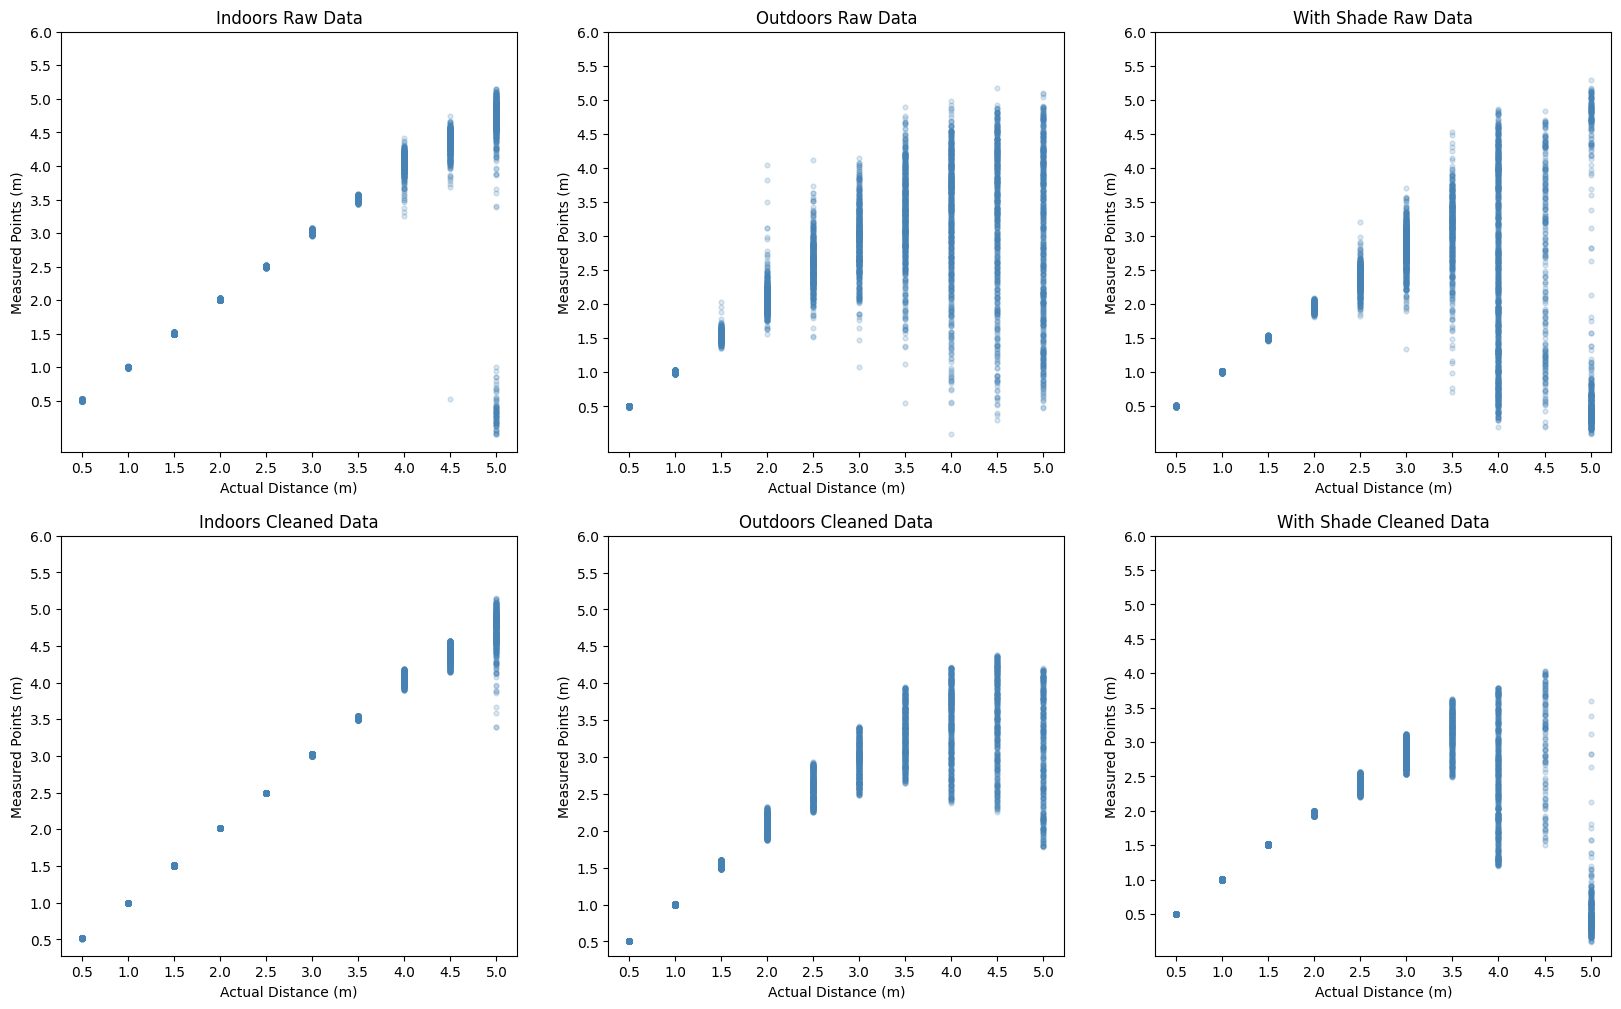

In [8]:
indoors_cleaned = cleaner.clean_basic_test_data(indoors_data.distances)
outdoors_cleaned = cleaner.clean_basic_test_data(outdoors_data.distances)
with_shade_cleaned = cleaner.clean_basic_test_data(with_shade_data.distances)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

basic_graphs.plot_scatter(axes[0][0], indoors_data.distances, "Indoors Raw Data")
basic_graphs.plot_scatter(axes[0][1], outdoors_data.distances, "Outdoors Raw Data")
basic_graphs.plot_scatter(axes[0][2], with_shade_data.distances, "With Shade Raw Data")

basic_graphs.plot_scatter(axes[1][0], indoors_cleaned, "Indoors Cleaned Data")
basic_graphs.plot_scatter(axes[1][1], outdoors_cleaned, "Outdoors Cleaned Data")
basic_graphs.plot_scatter(axes[1][2], with_shade_cleaned, "With Shade Cleaned Data")

plt.show()

- **Analysis**: The graphs illustrate that data cleaning yields varying degrees of improvement in sensor reliability. While outdoor readings saw a marginal shift in the slope from $0.62x$ to $0.67x$, the indoor data notably improved, moving from $0.88x$ to a near-perfect $0.96x$. Contrarily, the shaded data's reliability decreased, with the slope adjusting from $0.39x$ to $0.29x$, likely due to the removal of spurious data that previously averaged out the results. Thus, the primary focus should be mitigating errors from excessive natural light exposure, followed by secondary data cleaning to refine the dataset's reliability.

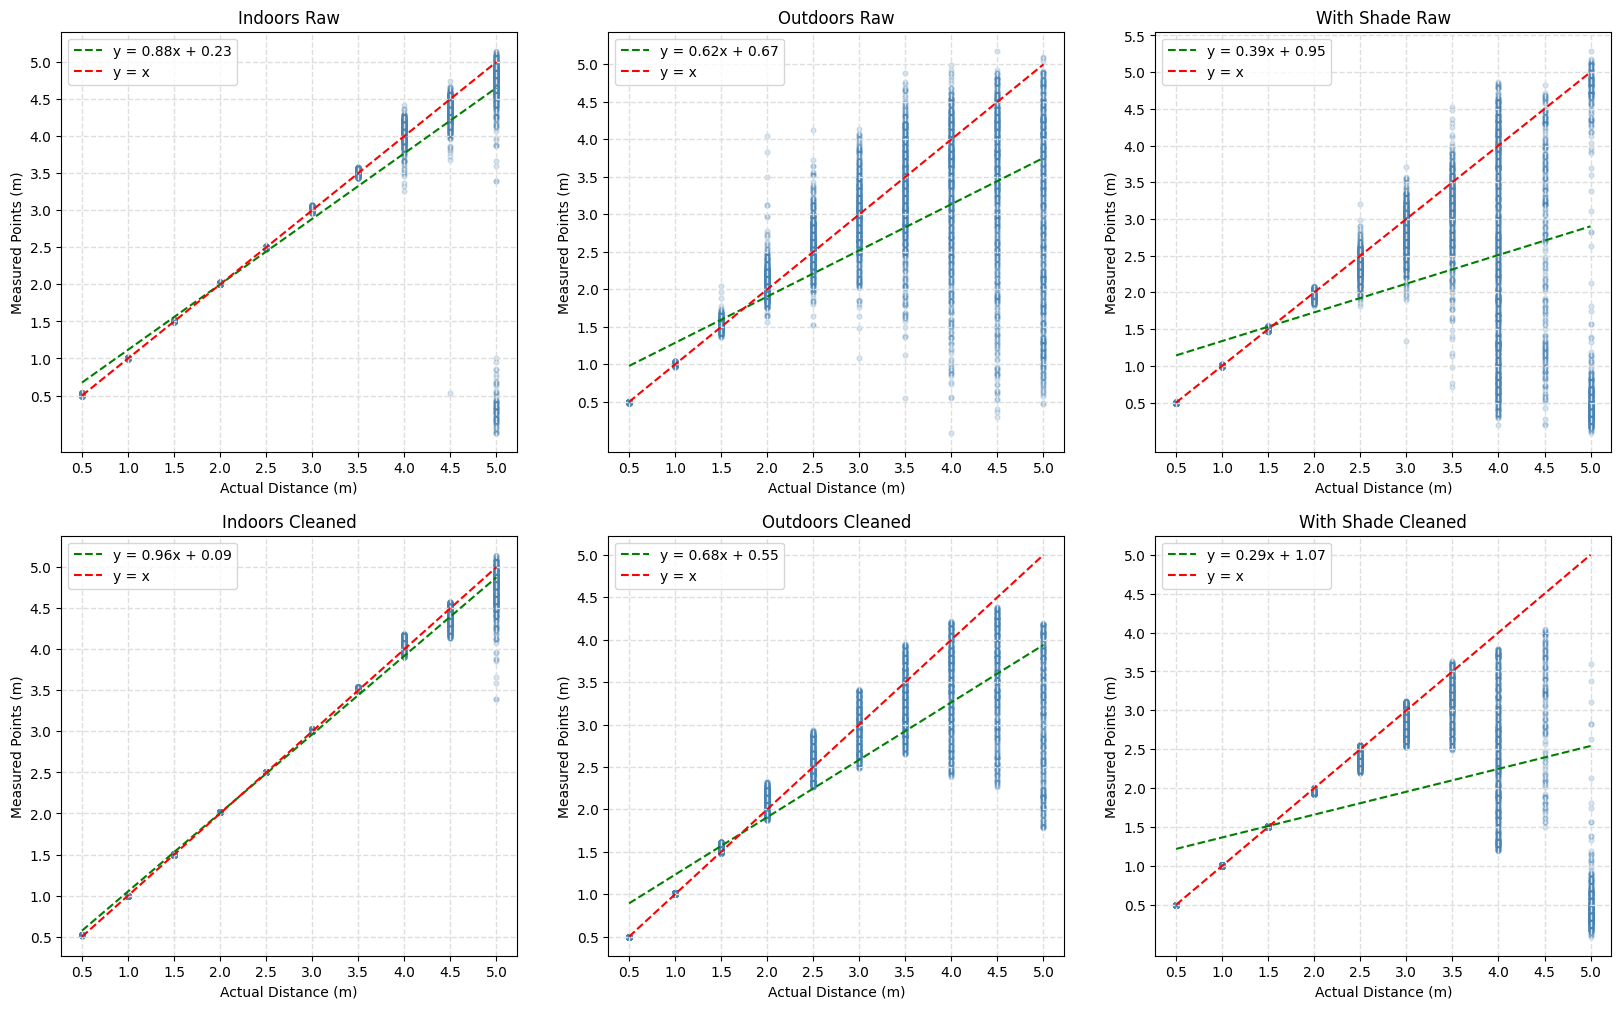

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

basic_graphs.plot_best_fit_scatter(axes[0][0], indoors_data.distances, "Indoors Raw")
basic_graphs.plot_best_fit_scatter(axes[0][1], outdoors_data.distances, "Outdoors Raw")
basic_graphs.plot_best_fit_scatter(axes[0][2], with_shade_data.distances, "With Shade Raw")

basic_graphs.plot_best_fit_scatter(axes[1][0], indoors_cleaned, "Indoors Cleaned")
basic_graphs.plot_best_fit_scatter(axes[1][1], outdoors_cleaned, "Outdoors Cleaned")
basic_graphs.plot_best_fit_scatter(axes[1][2], with_shade_cleaned, "With Shade Cleaned")

plt.show()

## Conclusion

Throughout our analysis, my findings spotlight the WaveShare TOF sensor's nuanced behavior under varying conditions:

1. **Accuracy**: The TOF sensor showcased impressive accuracy indoors, with measurements almost mirroring true values up to 4.0m. Outdoors, however, its performance plateaued at 3.0m, beyond which its readings waned. The added shade further impacted this, highlighting its sensitivity to minute adjustments and orientations.
2. **Precision**: Indoors, the sensor retained commendable precision, with minimal spurious data up to 3.5m. Conversely, outdoor results revealed pronounced variability, especially in bright daylight. Interestingly, the shade conferred better precision for closer distances, suggesting its potential utility for proximate readings.
3. **Standard Deviation**: Indoors, the TOF sensor exhibited a consistently low standard deviation until 4.5m. However, its outdoor performance, particularly under strong sunlight, deviated considerably after 2.0m. The shade, while aiding in closer distances, seemed to compromise readings for farther intervals.
4. **Best Fit Line**: Post-data cleaning, the indoor readings demonstrated a substantial leap towards the desired $y=x$ line, underscoring the benefits of data preprocessing. However, for outdoor and shaded data, the deviation from this ideal curve underscores the sensor's challenges in those conditions.

Therefore, in practice I would use the sensor with the case. The aim of the project is to measure vehicles which closely overtake the cyclist (i.e. less than 2m), and for such distances the casing would be a good way to enhance the sensor's accuracy and precision.